<a href="https://colab.research.google.com/github/Haibei1115/Subglacial-Discharge/blob/main/Modelling_Entrainment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Integration stopped at xc = 1.294666  (|Δ| ≈ 1e-06)


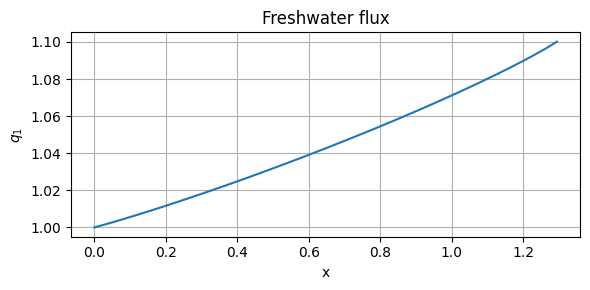

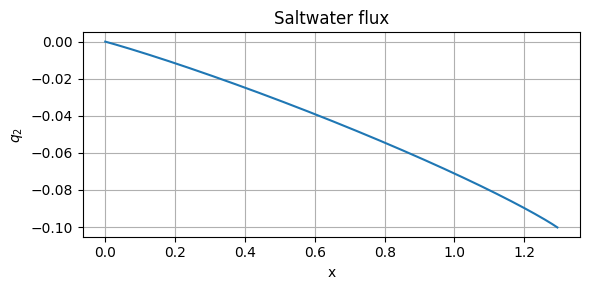

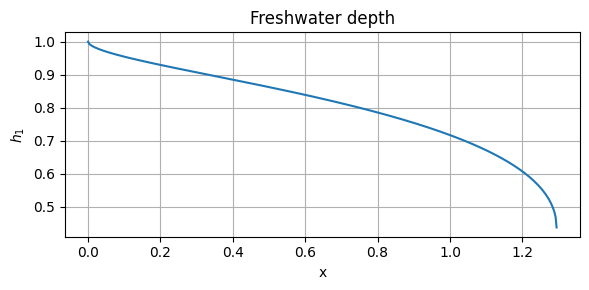

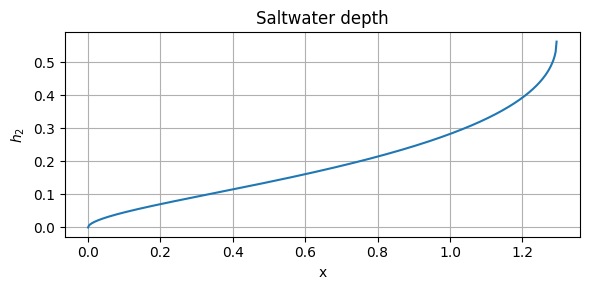

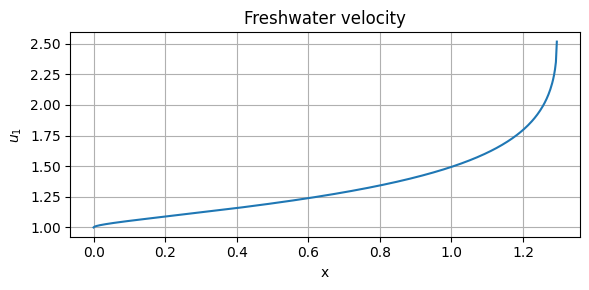

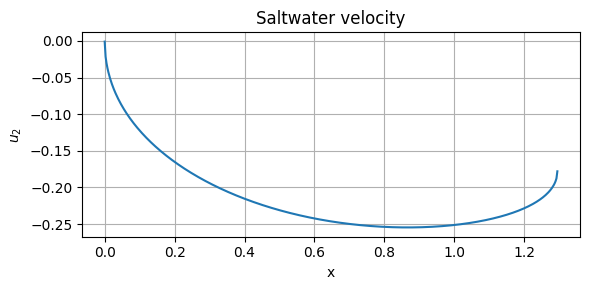

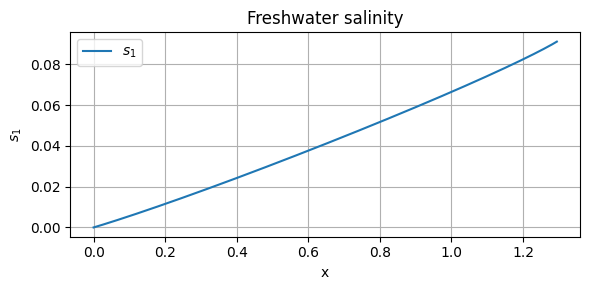

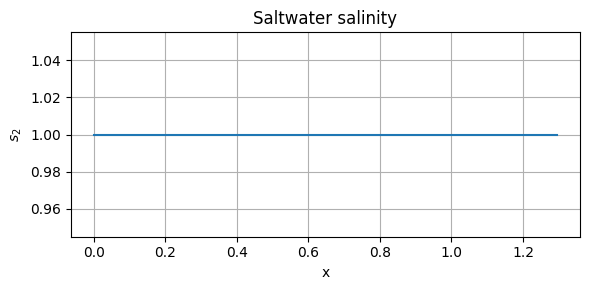

In [ ]:
"""
Two-layer plume in a rectangular channel (h ≡ 1):

solves the coupled ODEs for

    q1(x)  – discharge fraction of the fresh layer
    h1(x)  – thickness of the fresh layer
    s1(x)  – salinity of the fresh layer

with boundary values  q1(0)=1 , h1(0)=1 , s1(0)=Sm/S0.

Integration stops when the denominator Δ → 0 (hydraulic control point).
"""

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# 1. model-parameters (dimensionless)
A      = 0.05     # entrainment
F      = 0.25    # densimetric Froude number
C      = 0.1     # interfacial drag
S      = 0.0     # bed-slope
Sm_S0  = 0.0     # upstream salinity ratio  S_m / S_0
L      = 5    # downstream integration length

# numerical safety margins
EPS_Q   = 1e-8   # keeps q1 > 0
EPS_H   = 1e-5   # keeps 0 < h1 < 1
DEN_TOL = 1e-6   # integration stops when |Δ| ≈ DEN_TOL

F2 = F*F

# 2. right-hand side
def rhs(x, y):
    # dy/dx for y = [q1, h1, s1]
    q1, h1, s1 = y

    # keep variables inside their safe ranges
    q1 = max(q1, EPS_Q) # keeps q1 > 0
    h1 = np.clip(h1, EPS_H, 1.0-EPS_H) # keeps 0 < h1 < 1

    om_q1 = 1.0 - q1
    om_h1 = 1.0 - h1
    ΔU    = q1/h1 - om_q1/om_h1          # velocity difference

    # 1) dq1/dx
    dq1 = A * ΔU

    # 2) dh1/dx
    num = (A*F2*(q1/h1**2 + om_q1/om_h1**2)*ΔU
           + (C/om_h1 + A)*F2/h1*ΔU**2
           + F2*(q1**2/h1**3 - om_q1**2/om_h1**3)
           - (1.0-s1)*S)                 # dh/dx = 0 (rectangular)

    den = (-F2*q1**2/h1**3
           -F2*om_q1**2/om_h1**3
           + (1.0-s1))

    dh1 = -num / den

    # 3) ds1/dx
    ds1 = A * (1.0-s1) * ΔU / q1

    return [dq1, dh1, ds1]

# 3. event: approach the HCP/singularity of the denominator
def delta(q1, h1, s1):
    om_q1 = 1.0 - q1
    om_h1 = 1.0 - h1
    return (-F2*q1**2/h1**3
            -F2*om_q1**2/om_h1**3
            + (1.0-s1))

def near_singularity(x, y):
    q1, h1, s1 = y
    q1 = max(q1, EPS_Q)
    h1 = np.clip(h1, EPS_H, 1.0-EPS_H)
    return delta(q1, h1, s1) - DEN_TOL   # zero when Δ = DEN_TOL

near_singularit = lambda x, y: near_singularity(x, y)
near_singularit.terminal  = True
near_singularit.direction = 0

# 4. integrate the system
x0   = 0.0
y0   = [1.0+EPS_Q, 1.0-EPS_H, Sm_S0]   # small offset from the BC

sol = solve_ivp(rhs, (x0, L), y0,
                method="Radau",
                rtol=1e-6, atol=1e-8,
                max_step=0.1,
                events=[near_singularit],
                dense_output=True)

# check if HCP is found
if sol.t_events[0].size:
    xc = sol.t_events[0][0]
    print(f"Integration stopped at xc = {xc:.6f}  (|Δ| ≈ {DEN_TOL})")
else:
    print(f"Reached domain end  x = {sol.t[-1]:.6f}")

# 5. Plots
x_eval     = np.linspace(sol.t[0], sol.t[-1], 500)
q1, h1, s1 = sol.sol(x_eval)
q2 = 1 - q1
h2 = 1 - h1
s2 = np.ones_like(x_eval)
u1 = q1/h1
u2 = q2/h2

# q1
plt.figure(figsize=(6,3))
plt.plot(x_eval, q1, label=r"$q_1$")
plt.xlabel("x")
plt.ylabel("$q_1$")
plt.title("Freshwater flux")
plt.grid(True)
plt.tight_layout()

# q2
plt.figure(figsize=(6,3))
plt.plot(x_eval, q2, label=r"$q_2$")
plt.xlabel("x")
plt.ylabel("$q_2$")
plt.title("Saltwater flux")
plt.grid(True)
plt.tight_layout()

# h1
plt.figure(figsize=(6,3))
plt.plot(x_eval, h1, label=r"$h_1$")
plt.xlabel("x")
plt.ylabel(r"$h_1$")
plt.title("Freshwater depth")
plt.grid(True)
plt.tight_layout()

# h2
plt.figure(figsize=(6,3))
plt.plot(x_eval, h2, label=r"$h_2$")
plt.xlabel("x")
plt.ylabel(r"$h_2$")
plt.title("Saltwater depth")
plt.grid(True)
plt.tight_layout()

# u1
plt.figure(figsize=(6,3))
plt.plot(x_eval, u1, label=r"$u_1$")
plt.xlabel("x")
plt.ylabel(r"$u_1$")
plt.title("Freshwater velocity")
plt.grid(True)
plt.tight_layout()

# u2
plt.figure(figsize=(6,3))
plt.plot(x_eval, u2, label=r"$u_2$")
plt.xlabel("x")
plt.ylabel(r"$u_2$")
plt.title("Saltwater velocity")
plt.grid(True)
plt.tight_layout()

# s1
plt.figure(figsize=(6,3))
plt.plot(x_eval, s1, label=r"$s_1$")
plt.xlabel("x")
plt.ylabel(r"$s_1$")
plt.title("Freshwater salinity")
plt.grid(True)
plt.legend()
plt.tight_layout()

# s2
plt.figure(figsize=(6,3))
plt.plot(x_eval, s2, label=r"$s_2$")
plt.xlabel("x")
plt.ylabel(r"$s_2$")
plt.title("Saltwater salinity")
plt.grid(True)
plt.tight_layout()

plt.show()


q1_c = 52572173924724384.000000
h1_c = -4726326522877868466944367132672.000000
s1_c = 43432773657582472.000000
Δ(x_c) = -43432773657582472.000000
dh1_c = -31262437563361217671593984000000.000000
lhs_c = 1357814374673771865572869819713967243889748213760.000000
E_c = -0.0000000000


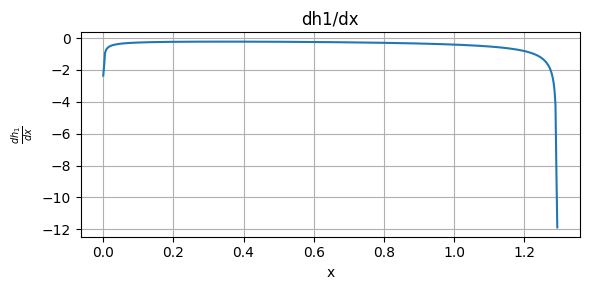

In [ ]:
## Checking lhs and rhs of ODE2

def delta(q1, h1, s1):
    om_q1 = 1.0 - q1
    om_h1 = 1.0 - h1
    return (-F2*q1**2/h1**3
            -F2*om_q1**2/om_h1**3
            + (1.0-s1))

def E_reg(q1, h1, h, s1):
    # Regularity expression that must vanish at x_c so that dh1/dx stays finite when delta goes to 0.
    om_q1 = 1.0 - q1
    om_h1 = 1  - h1
    dU    = q1/h1 - om_q1/om_h1

    term1 = A*F2*(q1/h1**2 + om_q1/om_h1**2) * dU
    term2 = (C*h/om_h1 + A) * F2/h1 * dU*dU
    term3 = F2*(q1**2/h1**3 - om_q1**2/om_h1**3)
    term4 = (1.0 - s1) * (0 + S)          # s2 = 1

    return term1 + term2 + term3 + term4, term1, term2, term3, term4

# xc = sol.t_events[0][0]
xc = 1.748213

q1_c, h1_c, s1_c = sol.sol(xc)
print(f"q1_c = {q1_c:.6f}")
print(f"h1_c = {h1_c:.6f}")
print(f"s1_c = {s1_c:.6f}")

delta_c = delta(q1_c, h1_c, s1_c)
print(f"Δ(x_c) = {delta_c:.6f}")

h1_fun = lambda x: sol.sol(x)[1]
dh1 = lambda x: np.gradient(h1_fun(x), x)
dh1_c = (h1_fun(xc + 1e-6) - h1_fun(xc - 1e-6))/(2*1e-6)
print(f"dh1_c = {dh1_c:.6f}")
lhs_c = delta_c * dh1_c
print(f"lhs_c = {lhs_c:.6f}")

E_c, term1, term2,term3,term4 = E_reg(q1_c, h1_c, 1, s1_c)
# print(f"term1 = {term1:.6f}")
# print(f"term2 = {term2:.6f}")
# print(f"term3 = {term3:.6f}")
# print(f"term4 = {term4:.6f}")
print(f"E_c = {E_c:.10f}")

# Plot of dh1/dx
plt.figure(figsize=(6, 3))
plt.plot(x_eval, dh1(x_eval), label=r"$\frac{dh_1}{dx}$")
plt.xlabel("x")
plt.ylabel(r"$\frac{dh_1}{dx}$")
plt.title("dh1/dx")
plt.grid(True)
plt.tight_layout()
plt.show()

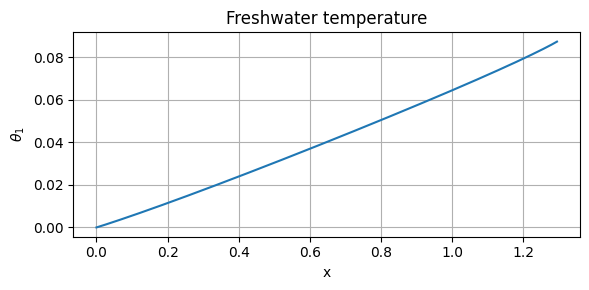

In [ ]:
## Temperature in the fresh-water layer: solve for t1(x)

# extra model parameters (dimensionless)
D          = 0.05      # vertical heat exchange coefficient between freshwater layer and ice
Gamma_hat  = 0.01       # salinity correction coefficient
t_m        = 0       # melting temperature  t1(0)

# interpolants for q1, h1, s1
# use the dense polynomial returned by sol.sol(·)
q1_fun = lambda x: sol.sol(x)[0]
h1_fun = lambda x: sol.sol(x)[1]
s1_fun = lambda x: sol.sol(x)[2]

# RHS for the temperature ODE
def rhs_t1(x, t1):
    q1 = max(q1_fun(x), EPS_Q)  # keep q1 > 0
    h1 = np.clip(h1_fun(x), EPS_H, 1.0-EPS_H)
    s1 = s1_fun(x)

    om_q1 = 1.0 - q1
    om_h1 = 1.0 - h1
    DeltaU = q1/h1 - om_q1/om_h1       # velocity difference ΔU

    # right-hand side from the equation
    dt1dx = (A * DeltaU * (1.0 - t1) / q1
             - D / h1 * (t1 + Gamma_hat * s1))
    return dt1dx

# integrate t1 from x = 0 to the same end-point as before (HCP)
t1_sol = solve_ivp(rhs_t1,
                   (x_eval[0], x_eval[-1]),        # same domain as q1,h1,s1
                   [t_m],                          # initial condition t1(0)
                   method="Radau",
                   rtol=1e-6, atol=1e-8,
                   t_eval=x_eval)                  # sample on the same grid

t1 = t1_sol.y[0]          # unpack solution with shape = (len(x_eval))

# 7. plot the temperature profile
plt.figure(figsize=(6, 3))
plt.plot(x_eval, t1, label=r"$\theta_1(x)$")
plt.xlabel("x")
plt.ylabel(r"$\theta_1$")
plt.title("Freshwater temperature")
plt.grid(True)
plt.tight_layout()
plt.show()

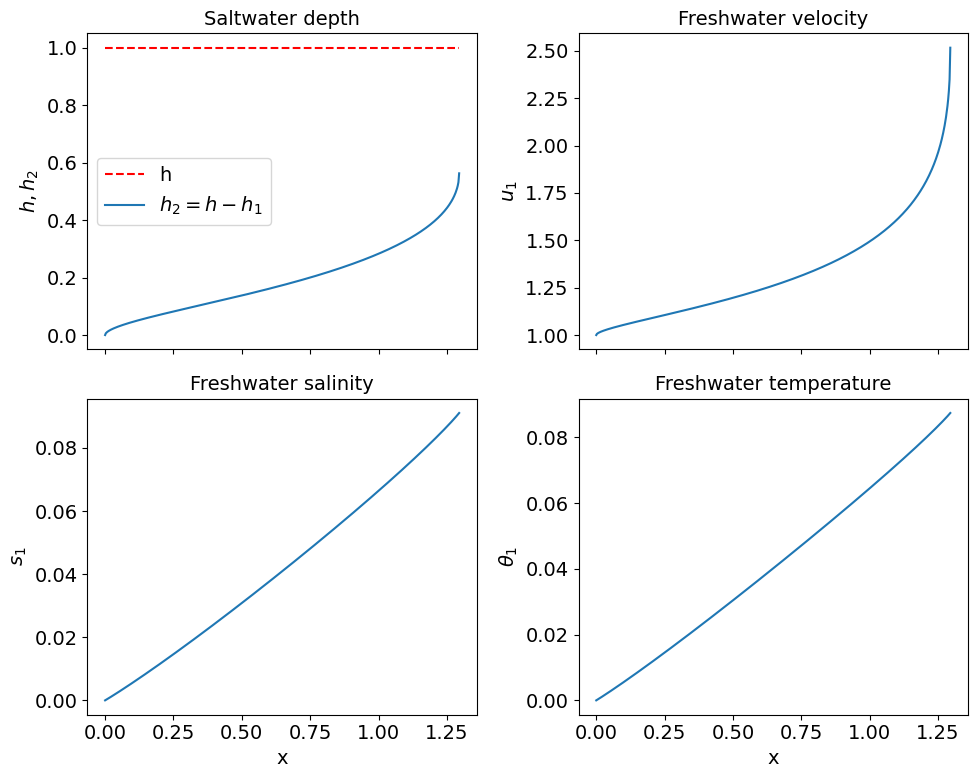

In [ ]:
import matplotlib.pyplot as plt

# --- assumes you already have: x_eval, h2, u1, s1, t1 ---

# Make all fonts 14 by default
plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
})

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)

channelheight = np.ones_like(x_eval)

# h1 (freshwater depth)
axes[0, 0].plot(x_eval, channelheight, 'r--', label = 'h')
# h2 (saltwater depth)
axes[0, 0].plot(x_eval, h2, label = r'$h_2 = h - h_1$')
axes[0, 0].set_ylabel(r"$h, h_2$")
axes[0, 0].set_title("Saltwater depth")
axes[0, 0].legend()
# axes[0, 0].grid(True, alpha=0.3)

# u1 (freshwater velocity)
axes[0, 1].plot(x_eval, u1)
axes[0, 1].set_ylabel(r"$u_1$")
axes[0, 1].set_title("Freshwater velocity")
# axes[0, 1].grid(True, alpha=0.3)

# s1 (freshwater salinity)
axes[1, 0].plot(x_eval, s1)
axes[1, 0].set_xlabel("x")
axes[1, 0].set_ylabel(r"$s_1$")
axes[1, 0].set_title("Freshwater salinity")
# axes[1, 0].grid(True, alpha=0.3)

# theta1 (freshwater temperature)
axes[1, 1].plot(x_eval, t1)
axes[1, 1].set_xlabel("x")
axes[1, 1].set_ylabel(r"$\theta_1$")  # <-- single backslash
axes[1, 1].set_title("Freshwater temperature")
# axes[1, 1].grid(True, alpha=0.3)

fig.tight_layout()
plt.show()

# Optional: save a publication-quality figure instead of showing it
# fig.savefig("two_layer_fields.pdf", bbox_inches="tight")
# fig.savefig("two_layer_fields.png", dpi=300, bbox_inches="tight")


xc = -2.287623
Ec = 1.053849


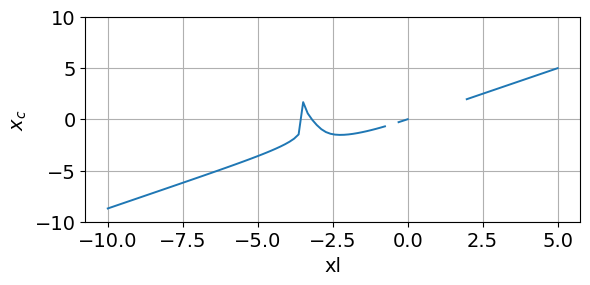

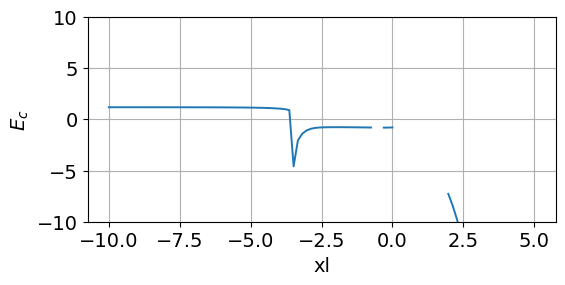

discrete minimum  R_min = -1.484405e+02  at  x_l = 5.000000


In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import brentq
import matplotlib.pyplot as plt

# 1) Model parameters (dimensionless)
A      = 0.05        # entrainment (set A=0.0 for "no entrainment" case)
F      = 0.25        # densimetric Froude number
C      = 0.10        # interfacial drag
S      = 0.00        # bed-slope term
Sm_S0  = 0.00        # upstream salinity ratio  S_m / S_0

# Numerical safety margins
EPS_Q   = 1e-8        # q1  > 0
EPS_H   = 1e-5        # 0 < h1 < h
EPS_S   = 1e-8
DEN_TOL = 1e-6        # Δ ≈ 0 tolerance in the event

F2 = F * F

# 2) Channel geometry (Exp channel)
def h_tot(x):    return 1.0 + np.exp(x)
def dhdx(x):     return       np.exp(x)

# 3) Auxiliary expressions

def delta(q1, h1, h_scalar, s1):
    """
    Hydraulic-control denominator Δ.
    NOTE: h_scalar must be a SCALAR (h(x)), not an array.
    """
    om_q1 = 1.0 - q1
    hm_h1 = h_scalar - h1
    return (
        -F2 * q1*q1 / h1**3
        -F2 * om_q1*om_q1 / hm_h1**3
        + (1.0 - s1)                     # s2 = 1
    )

def E_reg(q1, h1, h_scalar, dhdx_scalar, s1):
    """
    Regularity expression that must vanish at x_c so that dh1/dx stays finite when Δ→0.
    """
    om_q1 = 1.0 - q1
    hm_h1 = h_scalar - h1
    dU    = q1/h1 - om_q1/hm_h1

    term1 = A * F2 * ( q1/h1**2 + om_q1/hm_h1**2 ) * dU
    term2 = (C * h_scalar / hm_h1 + A) * F2 / h1 * dU*dU
    term3 = F2 * ( q1**2/h1**3 - om_q1**2/hm_h1**3 )
    term4 = (1.0 - s1) * (dhdx_scalar + S)         # s2 = 1, include dh/dx

    return term1 + term2 + term3 - term4

# 4) ODE right-hand side and Δ-event

def rhs(x, y):
    """
    dy/dx for y = [q1, h1, s1].
    All geometry (h, dh/dx) is computed LOCALLY from x (scalars).
    """
    q1, h1, s1 = y

    # channel geometry at this x (SCALARS!)
    h_scalar    = h_tot(x)
    dhdx_scalar = dhdx(x)

    # keep variables inside their safe ranges
    q1 = max(q1, EPS_Q)                       # keeps q1 > 0
    h1 = np.clip(h1, EPS_H, h_scalar - EPS_H) # keeps 0 < h1 < h

    om_q1 = 1.0 - q1
    om_h1 = h_scalar - h1
    dU    = q1/h1 - om_q1/om_h1               # velocity difference

    # 1) dq1/dx
    dq1 = A * dU

    # 2) dh1/dx (exp-channel: include dh/dx and S)
    num = (
        A * F2 * (q1/h1**2 + om_q1/om_h1**2) * dU
        + (C/om_h1 + A) * F2/h1 * dU**2
        + F2 * (q1**2/h1**3 - om_q1**2/om_h1**3)
        - (1.0 - s1) * (dhdx_scalar + S)
    )

    den = (
        -F2 * q1**2 / h1**3
        -F2 * om_q1**2 / om_h1**3
        + (1.0 - s1)
    )

    dh1 = -num / den

    # 3) ds1/dx
    ds1 = A * (1.0 - s1) * dU / q1

    return [dq1, dh1, ds1]

def near_singularity(x, y):
    """
    Event function: triggers when Δ ≈ DEN_TOL (approaching hydraulic control).
    """
    q1, h1, s1 = y
    h_scalar = h_tot(x)                        # SCALAR!
    q1 = max(q1, EPS_Q)
    h1 = np.clip(h1, EPS_H, h_scalar - EPS_H)
    return delta(q1, h1, h_scalar, s1) - DEN_TOL   # zero when Δ = DEN_TOL

# Configure event
near_singularit = lambda x, y: near_singularity(x, y)
near_singularit.terminal  = True
near_singularit.direction = 0

# 5) One forward integration given x_l

def integrate_from(xl, store_solution=False):
    h_l   = h_tot(xl + 1e-8)
    y0    = [1.0 + EPS_Q, h_l - EPS_H, EPS_S]   # q1, h1, s1

    sol = solve_ivp(
        rhs, (xl + 1e-8, 50), y0,
        method="Radau",
        rtol=1e-8, atol=1e-10,
        max_step=0.1,
        events=[near_singularit],
        dense_output=True
    )

    if sol.t_events[0].size:             # event found
        q1_c, h1_c, s1_c = sol.y[:, -1]
        x_c  = sol.t_events[0][0]
        # x_c  = sol.t_events[0][-1]
        # q1_c, h1_c, s1_c = sol.y_events[0][-1]

        h_c  = h_tot(x_c)
        dhdx_c = dhdx(x_c)
        E_c  = E_reg(q1_c, h1_c, h_c, dhdx_c, s1_c)
        return E_c, x_c, sol
    else:
        # No control point encountered: return a large non-zero value of E_c and x_c
        return np.nan, np.nan, None

# 6) Example: one run and scan over x_l

# Single example
E_c0, x_c0, _ = integrate_from(-4, store_solution=True)
print(f"xc = {x_c0:.6f}")
print(f"Ec = {E_c0:.6f}")

# Scan xl and observe Ec and xc
xspace = np.linspace(-10, 5, 100)
E_c_list = []
x_c_list = []

for xl in xspace:
    E_ci, x_ci, _ = integrate_from(xl, store_solution=True)
    E_c_list.append(E_ci)
    x_c_list.append(x_ci)

E_c_arr = np.asarray(E_c_list)
x_c_arr = np.asarray(x_c_list)

# 7) Plots

plt.figure(figsize=(6,3))
plt.plot(xspace, x_c_arr, lw=1.4, label=r"$x_c(x_l)$")
plt.xlabel("xl")
plt.ylabel(r"$x_c$")
plt.grid(True)
plt.tight_layout()
plt.ylim(-10, 10)
plt.show()

plt.figure(figsize=(6,3))
plt.plot(xspace, E_c_arr, lw=1.4, label=r"$E_c(x_l)$")
plt.xlabel("xl")
plt.ylabel(r"$E_c$")
plt.grid(True)
plt.tight_layout()
plt.ylim(-10, 10)
plt.show()

# 8) For low or no entrainment, E_c may never reach 0; find xl that minimizes E_c

# mask out NaNs and absurdly large values from spikes
mask    = np.isfinite(E_c_arr) & (np.abs(E_c_arr) < 1e3)

if np.any(mask):
    idx_min  = np.argmin(E_c_arr[mask])     # index in the masked array
    xl_min   = xspace[mask][idx_min]        # x_l at the minimum
    E_min    = E_c_arr[mask][idx_min]       # minimum residual
    print(f"discrete minimum  R_min = {E_min:.6e}  at  x_l = {xl_min:.6f}")
else:
    print("No valid E_c values found to compute a discrete minimum (all masked).")


The correct x_l = -3.527723
Corresponding x_c = nan
E_c at xl_root = 0.530251
Hydraulic-control point at x_c = -0.497244


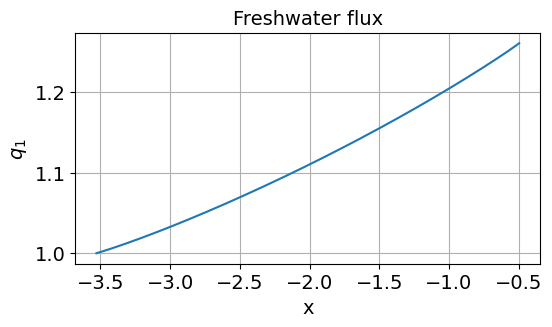

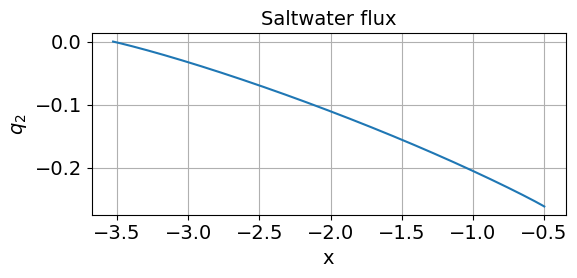

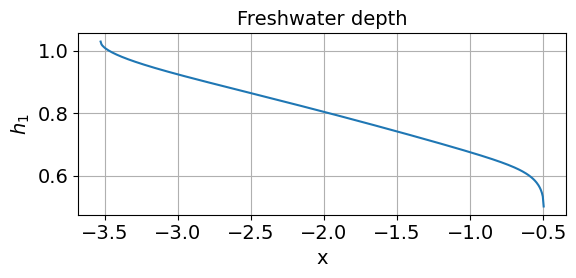

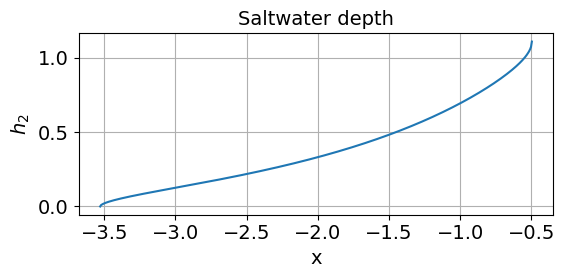

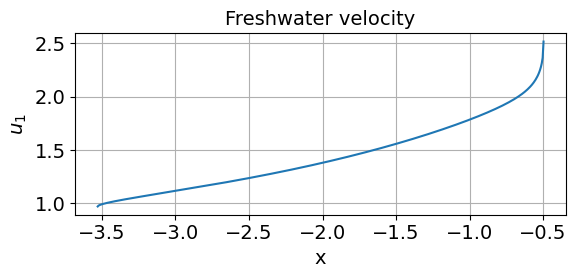

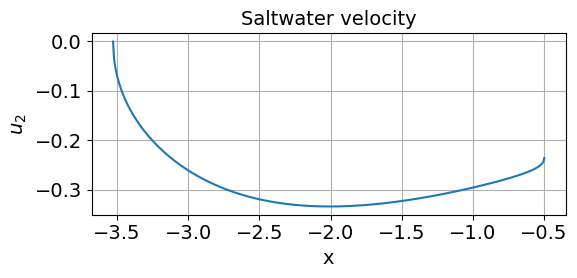

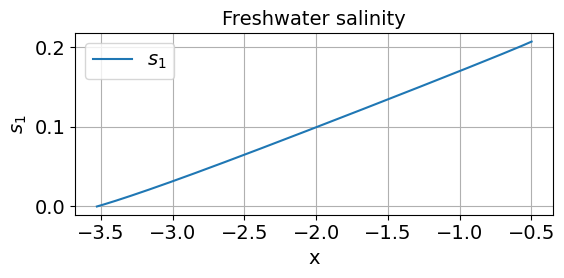

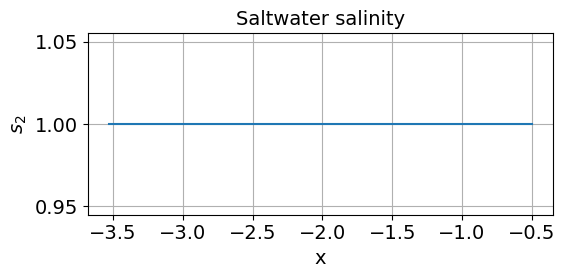

In [ ]:
# 6. shooting method: find xl such that  E_reg(x_c) = 0
import numpy as np

# XL_MIN = -6
# XL_MAX = -2

def bracket_root(f, a, b, n=100):
    # scan until f changes sign between some pair
    xs = np.linspace(a, b, n)
    fs = np.array([f(x) for x in xs])
    finite = np.isfinite(fs)
    xs = xs[finite]
    fs = fs[finite]

    for i in range(len(fs)-1):
        if fs[i] == 0:   return xs[i], xs[i]
        if fs[i]*fs[i+1] < 0:
            return xs[i], xs[i+1]
    # raise RuntimeError("Could not bracket the root; widen XL_MIN / XL_MAX.")
    return None, None

def search_xl(F, S, C, XL_MIN = -6, XL_MAX = -2):
    """
    Perform root-finding for x_l using brentq with integrate_from that returns both residual and x_c.
    """
    def residual_only(x_l):
        """
        Wrapper to get only the residual value for the root-finding search.
        """
        res, _, _= integrate_from(x_l, store_solution = False)  # Get the residual, ignore x_c
        return res

    # First, bracket the root using the coarse scan (bracket_root)
    xl_lo, xl_hi = bracket_root(residual_only, XL_MIN, XL_MAX)

    def residual_guarded(x):
        E, _, _ = integrate_from(x, store_solution=False)
        if np.isfinite(E):
            return float(E)
        # Event failed / solver blew up at this probe; keep bracketing alive
        # by returning a finite value with the endpoint sign for the half x is in.
        return Ea if x <= mid else Eb

    if xl_lo is not None:
        # Now, use brentq to find the root (xl_root) based on the residual
         # Evaluate once at endpoints (guaranteed finite by your scan)
        Ea = residual_only(xl_lo)
        Eb = residual_only(xl_hi)
        mid = 0.5*(xl_lo+xl_hi)
        xl_root = brentq(residual_guarded, xl_lo, xl_hi, xtol=1e-6)

       # Fallback: choose xl that minimizes |E| among finite residuals
    if xl_lo is None:
        xl_space = np.linspace(XL_MIN, XL_MAX, 200)
        E_vals = np.array([integrate_from(xl, store_solution=False)[0] for xl in xl_space],
                      dtype=float)
        finite_E = np.isfinite(E_vals)
        if finite_E.any():
            xl_root = xl_space[finite_E][np.argmin(np.abs(E_vals[finite_E]))]
        else:
            # nothing finite at all → decide how you want to handle this case
            xl_root = 0.5*(XL_MIN + XL_MAX)


        # E_arr = np.array(E_vals)
        # idx = np.nanargmin(np.abs(E_arr))
        # xl_root = xl_space[idx]

    # After finding xl_root, you can also access x_c by running integrate_from at xl_root
    _, x_c_root, _ = integrate_from(xl_root, store_solution = True)

    return xl_root, x_c_root

# Example usage
F, S, C = 0.25, 0.0, 0.1
xl_root, x_c_root = search_xl(F, S, C)
print(f"The correct x_l = {xl_root:.6f}")
print(f"Corresponding x_c = {x_c_root:.6f}")

# 7. final integration with dense output
# E_at_root, _, plume = integrate_from(xl_root, store_solution=True)
E_at_root, _, plume = integrate_from(xl_root - 1e-3, store_solution=True)
# E_at_root, _, plume = integrate_from(-3.494949, store_solution=True)
print(f"E_c at xl_root = {E_at_root:.6f}")
xc = plume.t[-1]
print(f"Hydraulic-control point at x_c = {xc:.6f}")

# sample solution
x_eval     = np.linspace(plume.t[0], plume.t[-1], 500)
q1, h1, s1 = plume.sol(x_eval)
h          = h_tot(x_eval)
q2         = 1.0 - q1
h2         = h - h1
s2 = np.ones_like(x_eval)
u1         = q1/h1
u2         = q2/h2

# 8. plots
# q1
plt.figure(figsize=(6,3))
plt.plot(x_eval, q1, label=r"$q_1$")
plt.xlabel("x")
plt.ylabel("$q_1$")
plt.title("Freshwater flux")
plt.grid(True)

# q2
plt.figure(figsize=(6,3))
plt.plot(x_eval, q2, label=r"$q_2$")
plt.xlabel("x")
plt.ylabel("$q_2$")
plt.title("Saltwater flux")
plt.grid(True)
plt.tight_layout()

# h1
plt.figure(figsize=(6,3))
plt.plot(x_eval, h1, label=r"$h_1$")
plt.xlabel("x")
plt.ylabel(r"$h_1$")
plt.title("Freshwater depth")
plt.grid(True)
plt.tight_layout()

# h2
plt.figure(figsize=(6,3))
plt.plot(x_eval, h2, label=r"$h_2$")
plt.xlabel("x")
plt.ylabel(r"$h_2$")
plt.title("Saltwater depth")
plt.grid(True)
plt.tight_layout()

# u1
plt.figure(figsize=(6,3))
plt.plot(x_eval, u1, label=r"$u_1$")
plt.xlabel("x")
plt.ylabel(r"$u_1$")
plt.title("Freshwater velocity")
plt.grid(True)
plt.tight_layout()

# u2
plt.figure(figsize=(6,3))
plt.plot(x_eval, u2, label=r"$u_2$")
plt.xlabel("x")
plt.ylabel(r"$u_2$")
plt.title("Saltwater velocity")
plt.grid(True)
plt.tight_layout()

# s1
plt.figure(figsize=(6,3))
plt.plot(x_eval, s1, label=r"$s_1$")
plt.xlabel("x")
plt.ylabel(r"$s_1$")
plt.title("Freshwater salinity")
plt.grid(True)
plt.legend()
plt.tight_layout()

# s2
plt.figure(figsize=(6,3))
plt.plot(x_eval, s2, label=r"$s_2$")
plt.xlabel("x")
plt.ylabel(r"$s_2$")
plt.title("Saltwater salinity")
plt.grid(True)
plt.tight_layout()

plt.show()

In [ ]:
# --- Temperature parameters (dimensionless) ---
D          = 0.05     # vertical heat exchange coefficient
Gamma_hat  = 0.01     # salinity correction coefficient
t_m        = 0.0      # melting temperature (θ1 at x=0)

# Interpolants for q1, h1, s1 from the plume solution
q1_fun = lambda x: plume.sol(x)[0]
h1_fun = lambda x: plume.sol(x)[1]
s1_fun = lambda x: plume.sol(x)[2]

# RHS of temperature ODE
def rhs_t1(x, t1):
    q1 = max(q1_fun(x), EPS_Q)                 # freshwater flux fraction
    h1 = np.clip(h1_fun(x), EPS_H, h_tot(x)-EPS_H)  # freshwater depth
    s1 = s1_fun(x)

    om_q1 = 1.0 - q1
    om_h1 = h_tot(x) - h1
    DeltaU = q1/h1 - om_q1/om_h1              # velocity difference ΔU

    # dθ1/dx
    dt1dx = (A * DeltaU * (1.0 - t1) / q1
             - D / h1 * (t1 + Gamma_hat * s1))
    return dt1dx

# Integrate θ1 from plume.t[0] to plume.t[-1]
t1_sol = solve_ivp(rhs_t1,
                   (x_eval[0], x_eval[-1]),
                   [t_m],
                   method="Radau",
                   rtol=1e-6, atol=1e-8,
                   t_eval=x_eval)

t1 = t1_sol.y[0]   # unpack



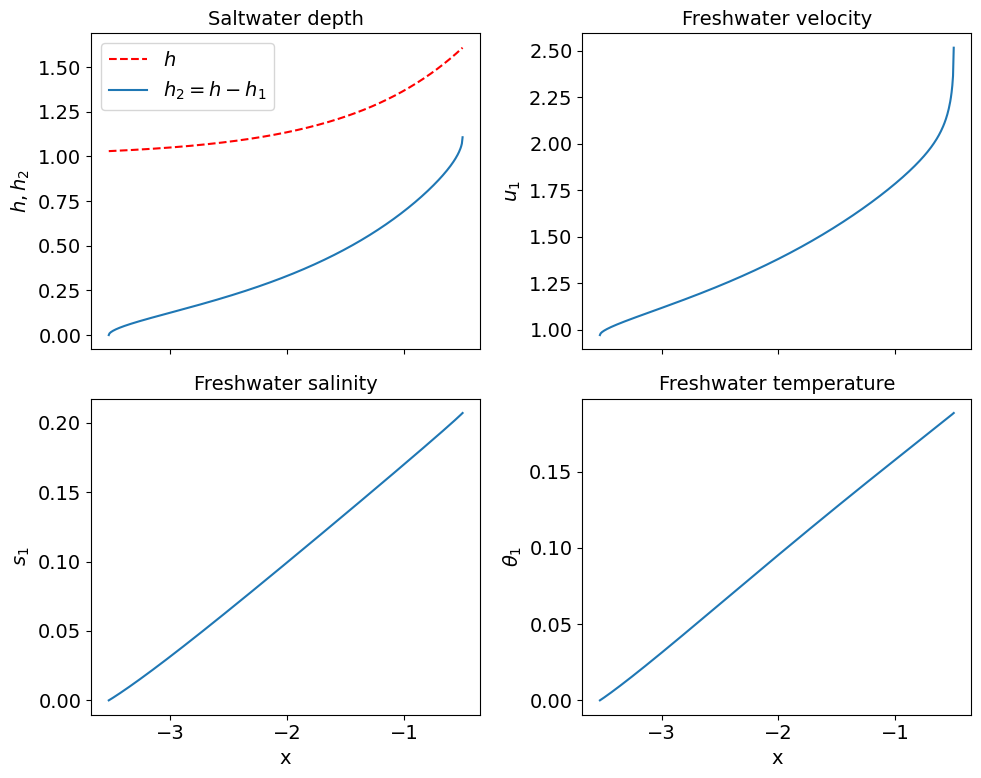

In [ ]:
# --- Make 2×2 subplot figure ---
plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
})

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)

# h2
axes[0, 0].plot(x_eval, h_tot(x_eval), "r--", label = r"$h$")
axes[0, 0].plot(x_eval, h2, color="C0", label = r"$h_2 = h - h_1$")
axes[0, 0].set_ylabel(r"$h, h_2$")
axes[0, 0].set_title("Saltwater depth")
axes[0, 0].legend()
# axes[0, 0].grid(True, alpha=0.4)

# u1
axes[0, 1].plot(x_eval, u1, color="C0")
axes[0, 1].set_ylabel(r"$u_1$")
axes[0, 1].set_title("Freshwater velocity")
# axes[0, 1].grid(True, alpha=0.4)

# s1
axes[1, 0].plot(x_eval, s1, color="C0")
axes[1, 0].set_xlabel("x")
axes[1, 0].set_ylabel(r"$s_1$")
axes[1, 0].set_title("Freshwater salinity")
# axes[1, 0].grid(True, alpha=0.4)

# θ1
axes[1, 1].plot(x_eval, t1, color="C0")
axes[1, 1].set_xlabel("x")
axes[1, 1].set_ylabel(r"$\theta_1$")
axes[1, 1].set_title("Freshwater temperature")
# axes[1, 1].grid(True, alpha=0.4)

plt.tight_layout()
plt.show()


A = 0.8 compared to A = 0.5:

intrusion length shorter, but salinity and temperature at xc higher due to higher mixing.